In this notebook, we examine rasters of the NYC area over the past 2 years. Using a machine learning model trained to classify different kinds land cover, adapated for this landscape, we can better characterize the kind of land cover to exist here, and what changes have occurred.

In [1]:
import sys
sys.path.append('src')
from src.trainer import EuroSATTrainer
from src.load_data import get_eurosat_dataloaders
from src.load_data import download_eurosat_data
import geopandas as gpd # for reading shapefiles
import folium  # library to create interactive maps
from shapely.geometry import MultiPolygon, Polygon
import os 
import rasterio as rio
from rasterio.mask import mask
import zipfile
import rasterio
import json
import shutil
import cv2
import numpy as np
from tqdm import tqdm
import torch
from collections import Counter
from datetime import datetime
import pandas as pd

# read credentials.json
with open('credentials.json') as f:
    credentials = json.load(f)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load model which performed best during training & validation
best_model_path = 'src/nyc-sentinel-src/3ivihb0d/checkpoints/epoch=49-step=15249.ckpt'
model = EuroSATTrainer.load_from_checkpoint(best_model_path)

if torch.cuda.is_available():
    model.to('cuda:0');
    print("Model sent to cuda.")



Model sent to cuda.


In [3]:
# create helper functions


def get_tiled_predictions(cropped_img,tile=64):
    """
    Splits the cropped input impage into 3x64x63 tiles, the same size as the training dataset, and independently predict
    the land cover type of each tile. 
    
    Using this approach, we recover an image of the same size as the input which serves as a pseudo mask of what land cover each tile is, 
    along with a list of predictions, images, and confidences for further downstream analysis.
    """
    img_height = raster.shape[1]
    img_width = raster.shape[2]

    tiled_array = np.zeros((cropped_img.shape[1],cropped_img.shape[2]))
    model.eval();
    tile_predictions = []
    tiled_images = []
    tiled_confidences = []
    tiled_indices = []
    with torch.no_grad():
        for i in range(0, img_height-tile, tile):
            for j in range(0, img_width-tile, tile):
                tiled_image = cropped_img[:,i:i+tile,j:j+tile]        
                if tiled_image.std() == 0:
                    tiled_array[i:i+tile,j:j+tile] = -1
                else:
                    x = torch.tensor(tiled_image.astype(np.int16))
                    x = (x - x.min()) / (x.max() - x.min())   
                    y_pred = model.forward(x.unsqueeze(0).cuda())
                    predicted_probs = y_pred.cpu().numpy()[0]
                    predicted_class = y_pred.argmax().cpu().item()
                    tiled_confidences.append(predicted_probs)
                    tiled_array[i:i+tile,j:j+tile] = predicted_class
                    tile_predictions.append(predicted_class)
                    tiled_images.append(tiled_image)
                    tiled_indices.append((i,j))

    return tile_predictions, tiled_array, tiled_images, tiled_confidences, tiled_indices




def crop_raster(raster,tile=64):
    """
    Crops the input raster into something which is divisible by the tile size used.

    Since the input dataset used 64x64 squares, that is the default tile size here. 
    """
    
    img_height = raster.shape[1]
    img_width = raster.shape[2]

    num_vertical_tiles = img_height // tile
    num_horizontal_tiles = img_width // tile
    return raster[:,:tile*num_vertical_tiles, :tile*num_horizontal_tiles]



def get_landmass_df(tile_predictions,date):
    """
    Following the tiled prediction of each Sentinel-2 image, return a table of all land cover counts and dates associated with this output.
        
    Useful for seeing trends over time. 
    """
    tile_counter = Counter(tile_predictions)
    landmass_counts = {}
    for key in tile_counter.keys():
        landmass = label_dict[key].replace('/','')
        if landmass in landmass_counts:
            landmass_counts[landmass] += tile_counter[key]
            
        else:
            landmass_counts[landmass] = tile_counter[key]
        landmass_counts['date'] = date
    landmass_df = pd.DataFrame([landmass_counts])
    return landmass_df

In [4]:
# grab label dictionary
_, _, _, label_dict = get_eurosat_dataloaders(batch_size = 1, limit=1, test_size = .1)
print(label_dict)

100%|██████████| 1/1 [00:00<00:00, 4826.59it/s]


{0: '/AnnualCrop', 1: '/Forest', 2: '/HerbaceousVegetation', 3: '/Highway', 4: '/Industrial', 5: '/Pasture', 6: '/PermanentCrop', 7: '/Residential', 8: '/River', 9: '/SeaLake'}


In [5]:
# Consolidate the classes into more reasonable ones for this task. This is described more in my blog post on the topic, here (https://nkasmanoff.github.io/blog)
label_dict = {0:'Seasonal Vegetation',
             1:'Forests',
             2:'Seasonal Vegetation',
             3:'Human Activity',
             4:'Human Activity',
             5:'Grass',
             6:'Permanent Vegetation',
             7:'Human Activity',
             8:'Water',
             9:'Water'}

In [6]:
# loop through the data collected from recent sentinel data, nd 
rasters = [f for f in os.listdir('data/') if f.endswith('.tiff')]
landmass_change_df = pd.DataFrame()
for img in tqdm(rasters):
    # open image
    date = img.split('_')[2].split('T')[0]
    raster = rio.open(f'data/{img}').read()
    cropped_img = crop_raster(raster)
    tile_predictions, tiled_array, tiled_images, tiled_confidences, tiled_indices = get_tiled_predictions(cropped_img)    
    year = date[:4]
    month = date[4:6]
    day = date[6:]
    date_str = f"{year}-{month}-{day}"
    date = datetime.strptime(date_str, '%Y-%m-%d')
    landmass_df = get_landmass_df(tile_predictions,date)
    landmass_change_df = landmass_change_df.append(landmass_df)

  0%|          | 0/21 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /media/nvidia/NVME/pytorch/pytorch-v1.9.0/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 21/21 [11:14<00:00, 32.10s/it]


In [7]:
landmass_change_df.fillna(0,inplace=True)
landmass_change_df_2022 = landmass_change_df[landmass_change_df['date'] > '2022-01-01']

landmass_change_df_2022_ = landmass_change_df_2022.copy() # use a copy of df to get % total of each landmass type
for col in landmass_change_df_2022.drop(columns=['date']).columns:
    landmass_change_df_2022[col] = landmass_change_df_2022[col] / landmass_change_df_2022_.drop(columns=['date']).sum(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
landmass_change_df_2022.sort_values('date')

,Water,date,Human Activity,Seasonal Vegetation,Forests,Grass,Permanent Vegetation
0,0.208661,2022-02-26,0.738189,0.052165,0.000984,0.000000,0.000000
0,0.220472,2022-03-21,0.714567,0.049213,0.000984,0.014764,0.000000
0,0.233268,2022-04-02,0.716535,0.047244,0.000984,0.000984,0.000984
0,0.248031,2022-04-12,0.687008,0.062992,0.000984,0.000984,0.000000
0,0.189961,2022-04-15,0.728346,0.063976,0.006890,0.010827,0.000000
0,0.220472,2022-04-20,0.712598,0.045276,0.001969,0.019685,0.000000
0,0.228346,2022-04-22,0.724409,0.038386,0.000984,0.007874,0.000000
0,0.190945,2022-04-30,0.740157,0.045276,0.006890,0.016732,0.000000
0,0.207677,2022-05-10,0.723425,0.043307,0.018701,0.006890,0.000000
0,0.169291,2022-06-04,0.743110,0.072835,0.007874,0.005906,0.000984


(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

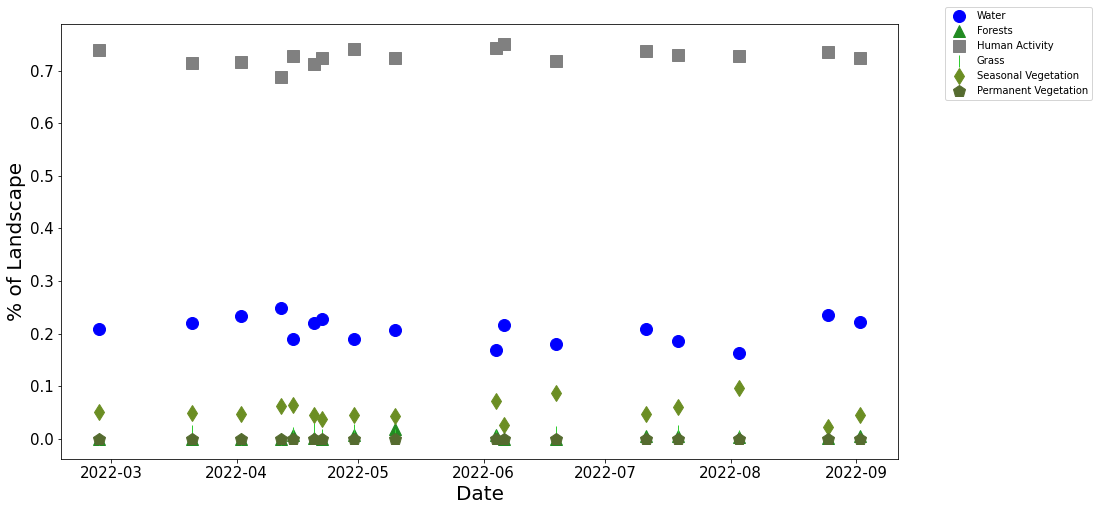

In [10]:
plt.figure(figsize=(15,8))
ax = plt.subplot(111)
plt.plot(landmass_change_df_2022['date'],landmass_change_df_2022['Water'],linewidth=0,marker='o',color='blue',markersize=12,label='Water')
plt.plot(landmass_change_df_2022['date'],landmass_change_df_2022['Forests'],linewidth=0,marker='^',color='forestgreen',markersize=12,label='Forests')
plt.plot(landmass_change_df_2022['date'],landmass_change_df_2022['Human Activity'],linewidth=0,marker='s',color='grey',markersize=12,label='Human Activity')
plt.plot(landmass_change_df_2022['date'],landmass_change_df_2022['Grass'],linewidth=0,marker='|',color='limegreen',markersize=12,label='Grass')
plt.plot(landmass_change_df_2022['date'],landmass_change_df_2022['Seasonal Vegetation'],linewidth=0,marker='d',color='olivedrab',markersize=12,label='Seasonal Vegetation')
plt.plot(landmass_change_df_2022['date'],landmass_change_df_2022['Permanent Vegetation'],linewidth=0,marker='p',color='darkolivegreen',markersize=12,label='Permanent Vegetation')
ax.legend(bbox_to_anchor=(1.05, 1.05))

plt.xlabel("Date",fontsize=20)
plt.ylabel("% of Landscape",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [11]:
# Create comparision images between the two rasters that above showed the most and least water. 

most_water_raster = rio.open('data/S2B_MSIL2A_20220412T153809_N0400_R011_T18TWL_20220412T210558.tiff').read()
least_water_raster = rio.open('data/S2B_MSIL2A_20220803T154819_N0400_R054_T18TWL_20220804T065759.tiff').read()

#cropped_img = crop_raster(raster)
#tile_predictions, tiled_array, tiled_images, tiled_confidences, tiled_indices = get_tiled_predictions(cropped_img)    
cropped_most_water_img = crop_raster(most_water_raster)
cropped_least_water_img = crop_raster(least_water_raster)

mw_img = cropped_most_water_img.mean(axis=0)
lw_img = cropped_least_water_img.mean(axis=0)

tile_mw_predictions, tiled_mw_array, tiled_mw_images, tiled_mw_confidences, tiled_mw_indices = get_tiled_predictions(cropped_most_water_img)    
tile_lw_predictions, tiled_lw_array, tiled_lw_images, tiled_lw_confidences, tiled_lw_indices = get_tiled_predictions(cropped_least_water_img)    


# label 8 and 9 were the two water types
mw_preds = [x for x in tile_mw_predictions if x in [8,9]]
lw_preds = [x for x in tile_lw_predictions if x in [8,9]]


# mask out anything not Water
most_water_mask = tiled_mw_array >= 8 
least_water_mask = tiled_lw_array >= 8 




([], [])

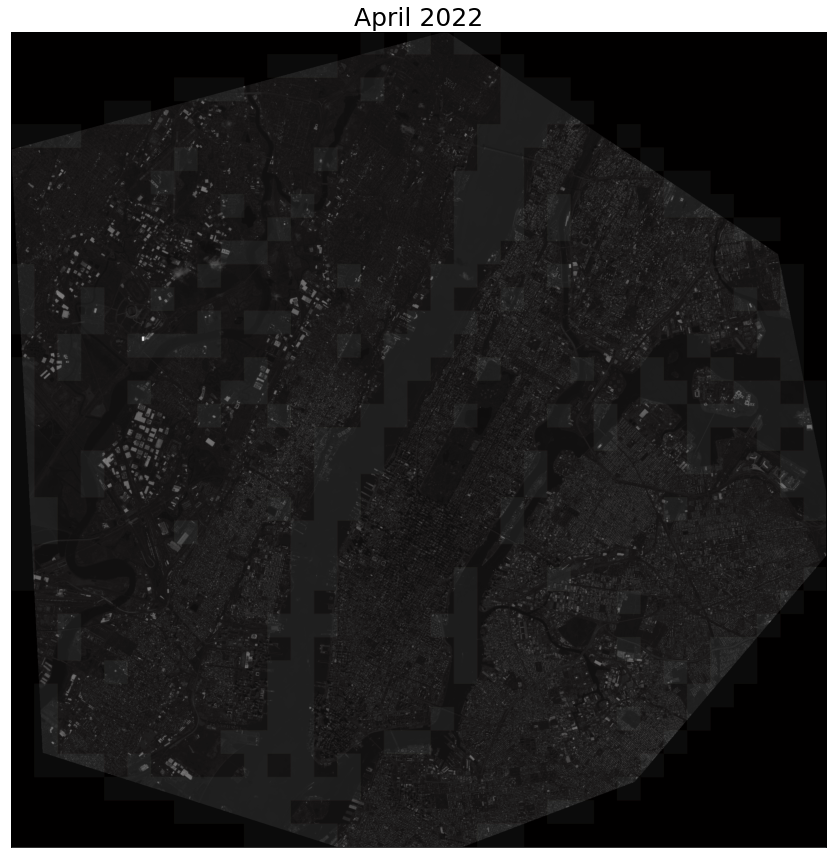

In [12]:
plt.figure(figsize=(15,15))
plt.title("April 2022",fontsize=25)
plt.imshow(mw_img,cmap='gray')
plt.imshow(most_water_mask,cmap='pink',alpha=.05)
plt.xticks([])
plt.yticks([])

([], [])

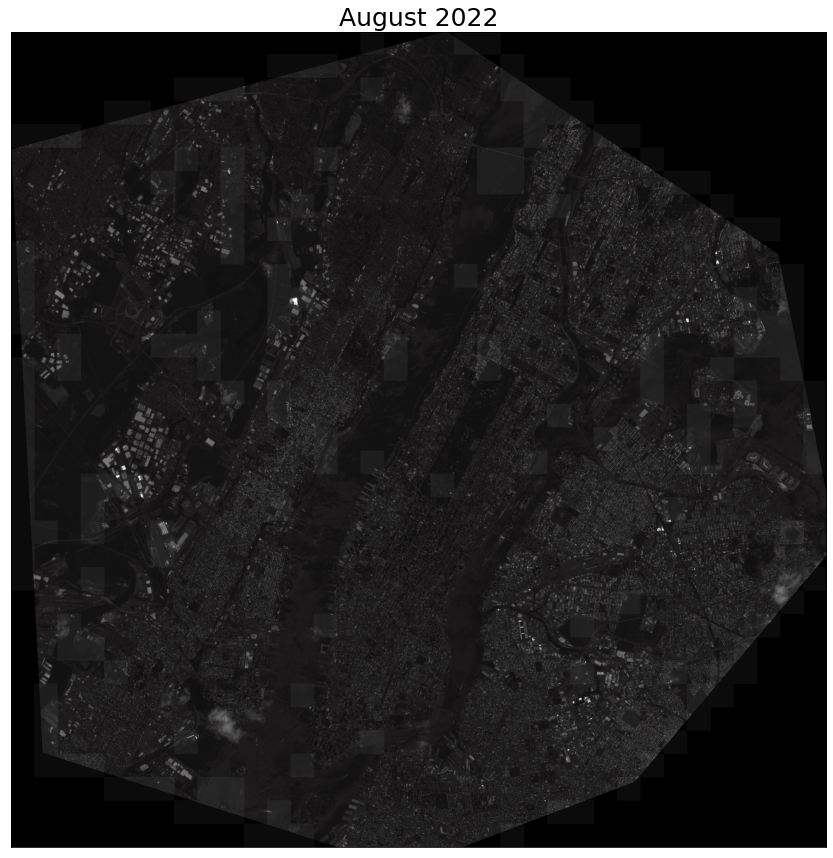

In [13]:
plt.figure(figsize=(15,15))
plt.title("August 2022",fontsize=25)
plt.imshow(lw_img,cmap='gray')
plt.imshow(least_water_mask
           ,cmap='pink',alpha=.05)
plt.xticks([])
plt.yticks([])

In [21]:
landmass_change_df_2022.sort_values('Human Activity')

,Water,date,Human Activity,Seasonal Vegetation,Forests,Grass,Permanent Vegetation
0,0.248031,2022-04-12,0.687008,0.062992,0.000984,0.000984,0.000000
0,0.220472,2022-04-20,0.712598,0.045276,0.001969,0.019685,0.000000
0,0.220472,2022-03-21,0.714567,0.049213,0.000984,0.014764,0.000000
0,0.233268,2022-04-02,0.716535,0.047244,0.000984,0.000984,0.000984
0,0.181102,2022-06-19,0.717520,0.087598,0.000000,0.012795,0.000984
0,0.207677,2022-05-10,0.723425,0.043307,0.018701,0.006890,0.000000
0,0.222441,2022-09-02,0.724409,0.046260,0.004921,0.001969,0.000000
0,0.228346,2022-04-22,0.724409,0.038386,0.000984,0.007874,0.000000
0,0.164370,2022-08-03,0.727362,0.097441,0.003937,0.005906,0.000984
0,0.189961,2022-04-15,0.728346,0.063976,0.006890,0.010827,0.000000


In [14]:
# next, I saved both of these images for gif generation as the easiest way to compare side by side. 
# to continue this avenue of study, I repeated this approach for human activity predictions.

In [35]:
# Create comparision images between the two rasters that above showed the most and least water. 

most_human_raster = rio.open('data/S2A_MSIL2A_20220606T153821_N0400_R011_T18TWL_20220606T230911.tiff').read()
least_human_raster = rio.open('data/S2B_MSIL2A_20220412T153809_N0400_R011_T18TWL_20220412T210558.tiff').read()

#cropped_img = crop_raster(raster)
#tile_predictions, tiled_array, tiled_images, tiled_confidences, tiled_indices = get_tiled_predictions(cropped_img)    
cropped_most_human_img = crop_raster(most_human_raster)
cropped_least_human_img = crop_raster(least_human_raster)

mh_img = cropped_most_human_img.mean(axis=0)
lh_img = cropped_least_human_img.mean(axis=0)

tile_mh_predictions, tiled_mh_array, tiled_mh_images, tiled_mh_confidences, tiled_mh_indices = get_tiled_predictions(cropped_most_human_img)    
tile_lh_predictions, tiled_lh_array, tiled_lh_images, tiled_lh_confidences, tiled_lh_indices = get_tiled_predictions(cropped_least_human_img)    


# label 8 and 9 were the two water types
mh_preds = [x for x in tile_mh_predictions if x in [3,4,7]]
lh_preds = [x for x in tile_lh_predictions if x in [3,4,7]]


# mask out anything not Human activity
most_human_mask = (tiled_mh_array == 3)  + (tiled_mh_array == 4) + (tiled_mh_array == 7)
least_human_mask = (tiled_lh_array == 3)  + (tiled_lh_array == 4) + (tiled_lh_array == 7)




([], [])

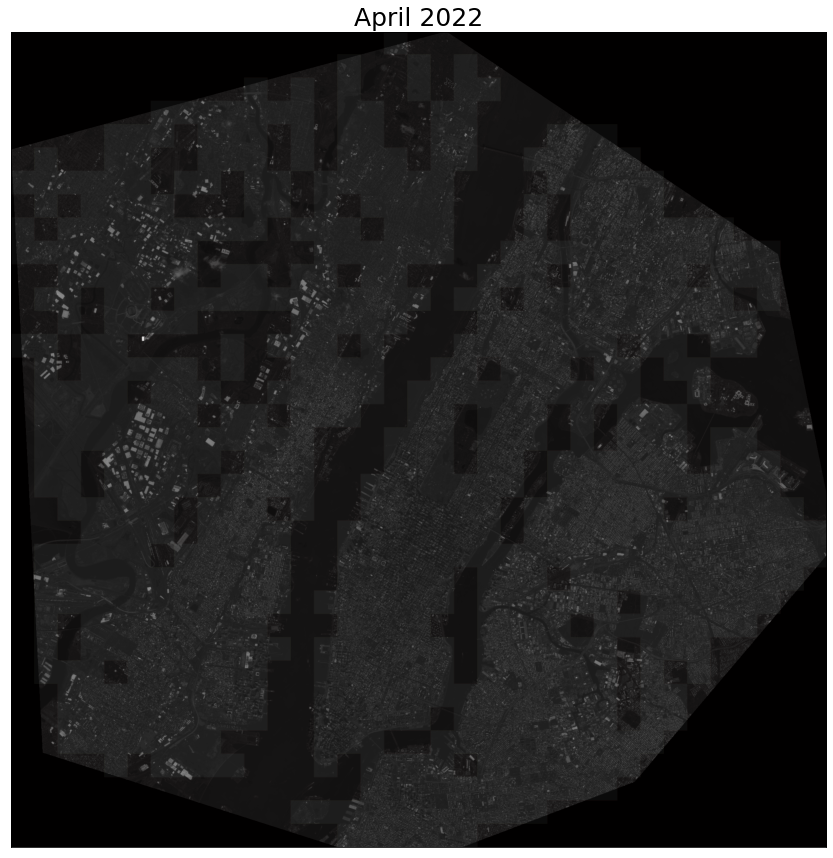

In [36]:
plt.figure(figsize=(15,15))
plt.title("April 2022",fontsize=25)
plt.imshow(lw_img,cmap='gray')
plt.imshow(least_human_mask
           ,cmap='pink',alpha=.05)
plt.xticks([])
plt.yticks([])

([], [])

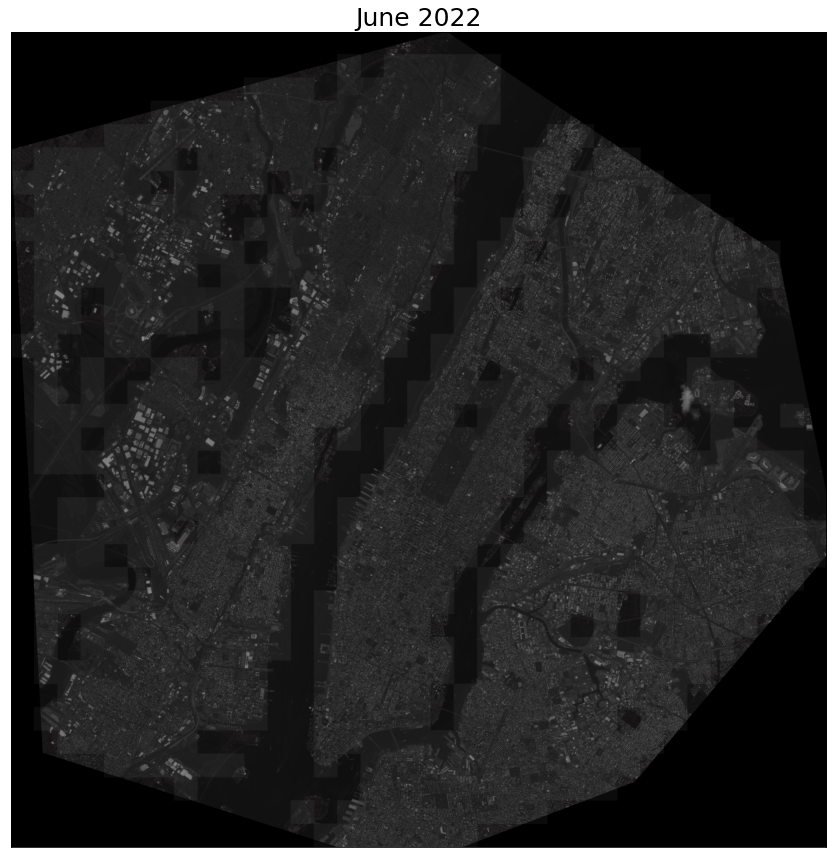

In [37]:
plt.figure(figsize=(15,15))
plt.title("June 2022",fontsize=25)
plt.imshow(mw_img,cmap='gray')
plt.imshow(most_human_mask
           ,cmap='pink',alpha=.05)
plt.xticks([])
plt.yticks([])

In [38]:
landmass_change_df_2022.corr()

,Water,Human Activity,Seasonal Vegetation,Forests,Grass,Permanent Vegetation
Water,1.000000,-0.442136,-0.706445,-0.333070,-0.332392,-0.498474
Human Activity,-0.442136,1.000000,-0.237157,0.168367,-0.046669,-0.014026
Seasonal Vegetation,-0.706445,-0.237157,1.000000,0.023940,0.110192,0.671579
Forests,-0.333070,0.168367,0.023940,1.000000,0.080829,-0.106105
Grass,-0.332392,-0.046669,0.110192,0.080829,1.000000,-0.124995
Permanent Vegetation,-0.498474,-0.014026,0.671579,-0.106105,-0.124995,1.000000


Some observations from this: 

- Water is negatively correlated with everything! 

This has two consequences. The first is that the mistakes of the model were between either water or natural land cover, meaning a decrease in one led to in an increase in the other. The second conclusion is linked to the first, in that as water levels lower, that land is replaced with natural land cover, hence the increase in predictions. 

Due to the rigid predictions here (based on 64x64 tiles) I'm not sure that the latter reason is the primary driver here, but is a worthy follow up in a future study. I'll try to get my hands on a segmentation dataset, and repeat this study then!



